+ cv 기반 stacking을 시도하였다.
parameter을 지정하면 underfit, 지정하지않으면 overfit이 된다.

+ catboost 방법을 추천받았다.

+ scaring을 해보라고 추천받았다.

+ train_set 과 valid_set이 어디냐에 따라 모델 성능이 현저하게 차이났다.
고정시킬 필요가 있을 것 같다.

+ cv 기반 stacking을 predict_proba로 변환해서 시도해보는것이 좋을 것같다.

+ 기존 최고 성능 모델을 돌려봤지만, train data 가 달라짐에 따라 성능이 똑같이 나오지 않는다.

1. drop_columns = ['out_prncp_inv', 'funded_amnt_inv', 'installment', 'initial_list_status'] 컬럼을 삭제(유지)
2. fico_range_low, fico_range_low 는 1의 상관관계인데 다른데이터를 가지고 있다. 더 분석이 필요할 것 같다. -> 없어지면 모델 설명력이 떨어진다. 유지하기로 결정했다.

3. imbalanced data를 해결하기 위한 방법을 찾아봐야겠다.(over sampling, under sampling) -> 별다른 성능 향상을 가져오진 못했다
4. cost-sensitive learning 방법도 시도해보는게 좋을것 같다.(블로그 추천)

5. 현재까지 가장 좋은 성능을 보이는 parameter + threshold = 0.42
rnd_clf = RandomForestClassifier(max_depth = 20)
xgb_clf = xgboost.XGBClassifier(max_depth = 6,
                                n_estimators = 100,
                                eval_metric='mlogloss')
lgbm_clf = LGBMClassifier(max_depth=10,
                                  num_leaves =120)
6. 앞으로 시도해보면 좋을 일
- over sampling , under sampling, cost-sensitive learning
- 트리의 깊이에 대한 고민

# threshold를 0.42로 바꿔봤다... 성능이 훨씬 좋아졌다.
0.41과 0.43으로도 변경해봐야하나 고민된다..

현재 모델
rnd_clf = RandomForestClassifier(max_depth = 20)
xgb_clf = xgboost.XGBClassifier(max_depth = 6,
                                n_estimators = 100,
                                eval_metric='mlogloss')
lgbm_clf = LGBMClassifier(max_depth=10,
                                  num_leaves =120)


stacking_clf = StackingClassifier(estimators=[('rnd', rnd_clf),('lgbm', lgbm_clf), ('xgb', xgb_clf)], final_estimator = LGBMClassifier(), stack_method = 'predict_proba')

In [1]:
# !pip install pandas
# !pip install numpy
# !pip install seaborn
# !pip install matplotlib
# !pip install xgboost
# !pip install lightgbm
# !pip install sklearn

# 라이브러리 임포트
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import xgboost
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, BaggingClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, RidgeCV, RidgeClassifier
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV

import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# EDA

## 변수 설명
  - **int_rate** : 대출자에 부여된 이자율 (Interest rate of the loan the applicant received)
  - **annual_inc** : 연 소득 (annual income)
  - **dti** : 소득 대비 부채 비율 (Debt-to-income ratio)
  - **delinq_2yrs** : 지난 2년 간 체납 발생 횟수 (Delinquencies on lines of credit in the last 2 years)
  - **inq_last_6mths** : 지난 6개월 간 신용 조회 수 (Inquiries into the applicant's credit during the last 6 months)
  - **pub_rec** : 파산 횟수 (Number of bankruptcies listed in the public record)
  - **revol_bal** : 리볼빙 잔액 (Total credit revolving balance)
  - **total_acc** : 지금까지 소유했던 신용카드 개수 (num_total_cc_accounts : Total number of credit card accounts in the applicant's history)
  - **collections_12_mths_ex_med** : 의료부문을 제외한 지난 12개월 간 추심 발생 횟수 (num_collections_last_12m : Number of collections in the last 12 months. This excludes medical collections)
  - **acc_now_delinq** : 대출자가 체납 상태에 있지 않은 계좌의 수 (The number of accounts on which the borrower is now delinquent)
  - **tot_coll_amt** : 대출자에 대한 현재까지의 총 추심액 (total_collection_amount_ever : The total amount that the applicant has had against them in collections)
  - **tot_cur_bal** : 전 계좌의 현재 통합 잔고 (Total current balance of all accounts)
  - **chargeoff_within_12_mths** : 대출 부 신청인의 대출 신청 직전 12개월 간 세금 공제 횟수 (Number of charge-offs within last 12 months at time of application for the secondary applicant)
  - **delinq_amnt** : 체납 금액 (delinquency amount)
  - **tax_liens** : 세금 저당권의 수 (Number of tax liens)
  - **emp_length1 ~ 12** : 고용 연수 (Number of years in the job)
  - **home_ownership1 ~ 6** : 대출 신청자의 주거 소유 형태 (The ownership status of the applicant's residence)
  - **verification_status1 ~ 3** : 공동 소득 발생 여부 및 형태 (verification_income_joint : Type of verification of the joint income)
  - **purpose1 ~ 14** : 대출 목적 (The purpose of the loan)
  - **initial_list_status1 ~ 2** : 최초 대출 상태 (Initial listing status of the loan)
  - **mths_since_last_delinq1 ~ 11** : 마지막 체납이 지금으로부터 몇개월 전에 있었는지를 나타내는 변수 (Months since the last delinquency)
  
  - **funded_amnt** : 대출액 (Funded amount)
  - **funded_amnt_inv** : 사채 대출액 (Funded amount by investors)
  - **total_rec_late_fee** : 총 연체료 중 납부액 (Late fees received to date)
  - **term1** : 상환 기간 (The number of payments on the loan. Values are in months and can be either 36 or 60)
  - **open_acc** : 개설 개좌 수 (The number of open credit lines in the borrower's credit file)
  - **installment** : 대출 발생 시 월 상환액 (The monthly payment owed by the borrower if the loan originates)
  - **revol_util** : 리볼빙 한도 대비 리볼빙 사용 비율 (Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit)
  - **out_prncp** : 대출액 중 원리금 잔액 (Remaining outstanding principal for total amount funded)
  - **out_prncp_inv** : 사채 대출액 중 원리금 잔액 (Remaining outstanding principal for total amount funded by investors)
  - **total_rec_int** : 이자 상환액 (Interest received to date)
  - **fico_range_low** : FICO(일종의 신용점수) 최저값 (The lower boundary range the borrower’s FICO at loan origination belongs to)
  - **fico_range_high** : FICO(일종의 신용점수) 최고값 (The upper boundary range the borrower’s FICO at loan origination belongs to)
  
  - **depvar** : 고객의 부도 여부 (dependent variable)

In [2]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/20220126_DAY27(1주차 모의경진대회)/train.csv')
df.head(10)

,int_rate,annual_inc,dti,delinq_2yrs,inq_last_6mths,pub_rec,revol_bal,total_acc,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,chargeoff_within_12_mths,delinq_amnt,tax_liens,emp_length1,emp_length2,emp_length3,emp_length4,emp_length5,emp_length6,emp_length7,emp_length8,emp_length9,emp_length10,emp_length11,emp_length12,home_ownership1,home_ownership2,home_ownership3,home_ownership4,home_ownership5,home_ownership6,verification_status1,verification_status2,verification_status3,purpose1,purpose2,purpose3,purpose4,purpose5,purpose6,purpose7,purpose8,purpose9,purpose10,purpose11,purpose12,purpose13,purpose14,initial_list_status1,initial_list_status2,mths_since_last_delinq1,mths_since_last_delinq2,mths_since_last_delinq3,mths_since_last_delinq4,mths_since_last_delinq5,mths_since_last_delinq6,mths_since_last_delinq7,mths_since_last_delinq8,mths_since_last_delinq9,mths_since_last_delinq10,mths_since_last_delinq11,funded_amnt,funded_amnt_inv,total_rec_late_fee,term1,open_acc,installment,revol_util,out_prncp,out_prncp_inv,total_rec_int,fico_range_low,fico_range_high,depvar
0,0.0824,21000.0,29.19,0,1,0,3016,26,0,0,0,11773,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1200,1200.0,0.0,1,18,37.74,0.076,0.0,0.0,157.94,765,769,0
1,0.1299,80000.0,4.82,0,1,1,5722,24,0,0,0,21875,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,8000,8000.0,0.0,1,8,269.52,0.447,0.0,0.0,1702.42,665,669,0
2,0.1299,38000.0,23.66,0,3,0,6511,18,0,0,0,31868,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,5000,5000.0,0.0,1,7,168.45,0.880,0.0,0.0,1066.64,670,674,0
3,0.1367,100000.0,16.27,4,2,0,6849,30,0,0,0,326049,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,15000,15000.0,0.0,1,12,510.27,0.457,0.0,0.0,1256.24,680,684,1
4,0.1269,30000.0,25.28,0,1,2,8197,12,0,0,2506,8840,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,10000,10000.0,0.0,1,8,335.45,0.416,0.0,0.0,871.04,660,664,1
5,0.1318,90000.0,3.48,7,0,0,2903,31,0,0,0,19548,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,7000,7000.0,0.0,1,7,236.47,0.854,0.0,0.0,1330.30,660,664,0
6,0.0791,60000.0,17.34,0,0,0,20399,35,0,0,0,117320,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,20000,20000.0,0.0,1,18,625.90,0.369,0.0,0.0,2567.44,750,754,0
7,0.0975,79600.0,15.97,3,0,1,6481,17,0,0,0,18757,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,23800,23800.0,0.0,1,7,765.17,0.745,0.0,0.0,3006.76,680,684,0
8,0.0789,150000.0,7.36,1,0,0,15827,38,0,0,543,367504,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,16000,16000.0,0.0,1,19,500.58,0.334,0.0,0.0,1286.38,665,669,0
9,0.0999,95000.0,25.78,0,1,0,17870,37,0,0,0,273776,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,8000,8000.0,0.0,1,24,258.10,0.764,0.0,0.0,796.59,665,669,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 76 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   int_rate                    100000 non-null  float64
 1   annual_inc                  100000 non-null  float64
 2   dti                         100000 non-null  float64
 3   delinq_2yrs                 100000 non-null  int64  
 4   inq_last_6mths              100000 non-null  int64  
 5   pub_rec                     100000 non-null  int64  
 6   revol_bal                   100000 non-null  int64  
 7   total_acc                   100000 non-null  int64  
 8   collections_12_mths_ex_med  100000 non-null  int64  
 9   acc_now_delinq              100000 non-null  int64  
 10  tot_coll_amt                100000 non-null  int64  
 11  tot_cur_bal                 100000 non-null  int64  
 12  chargeoff_within_12_mths    100000 non-null  int64  
 13  delinq_amnt    

In [4]:
df.describe()

,int_rate,annual_inc,dti,delinq_2yrs,inq_last_6mths,pub_rec,revol_bal,total_acc,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,chargeoff_within_12_mths,delinq_amnt,tax_liens,emp_length1,emp_length2,emp_length3,emp_length4,emp_length5,emp_length6,emp_length7,emp_length8,emp_length9,emp_length10,emp_length11,emp_length12,home_ownership1,home_ownership2,home_ownership3,home_ownership4,home_ownership5,home_ownership6,verification_status1,verification_status2,verification_status3,purpose1,purpose2,purpose3,purpose4,purpose5,purpose6,purpose7,purpose8,purpose9,purpose10,purpose11,purpose12,purpose13,purpose14,initial_list_status1,initial_list_status2,mths_since_last_delinq1,mths_since_last_delinq2,mths_since_last_delinq3,mths_since_last_delinq4,mths_since_last_delinq5,mths_since_last_delinq6,mths_since_last_delinq7,mths_since_last_delinq8,mths_since_last_delinq9,mths_since_last_delinq10,mths_since_last_delinq11,funded_amnt,funded_amnt_inv,total_rec_late_fee,term1,open_acc,installment,revol_util,out_prncp,out_prncp_inv,total_rec_int,fico_range_low,fico_range_high,depvar
count,100000.000000,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.0,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.130833,7.436061e+04,18.514508,0.343700,0.668880,0.235720,16090.202820,24.675910,0.018810,0.005800,250.588120,1.305281e+05,0.009630,19.288330,0.063820,0.065400,0.326240,0.089410,0.08058,0.059480,0.060710,0.046640,0.045320,0.045690,0.038570,0.075550,0.066410,0.000330,0.466120,0.000070,0.000050,0.110880,0.422550,0.321800,0.390200,0.288000,0.009620,0.226720,0.582810,0.0,0.060400,0.004250,0.019830,0.01101,0.007310,0.058200,0.000650,0.011250,0.007070,0.000880,0.434430,0.565570,0.489320,0.052360,0.060090,0.045700,0.050750,0.048560,0.051340,0.053430,0.048960,0.050030,0.049460,13735.317750,13729.341073,2.448885e+00,0.855920,11.620700,434.077648,0.537233,0.253327,0.253259,2491.282802,692.630550,696.630660,0.325690
std,0.044773,7.467409e+04,8.413049,0.905007,0.952044,0.661468,21569.939271,11.883834,0.150321,0.083585,2042.770881,1.503326e+05,0.110079,893.304366,0.468027,0.247232,0.468839,0.285336,0.27219,0.236522,0.238799,0.210868,0.208006,0.208813,0.192569,0.264278,0.248999,0.018163,0.498853,0.008366,0.007071,0.313985,0.493968,0.467169,0.487797,0.452833,0.097609,0.418712,0.493097,0.0,0.238228,0.065054,0.139417,0.10435,0.085186,0.234122,0.025487,0.105468,0.083786,0.029652,0.495684,0.495684,0.499888,0.222753,0.237655,0.208835,0.219488,0.214947,0.220691,0.224891,0.215786,0.218008,0.216828,8464.825314,8461.694483,1.489496e+01,0.351173,5.458774,265.921746,0.239373,18.053290,18.051746,2706.262200,29.668017,29.668584,0.468634
min,0.053200,5.360000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,

In [5]:
# 결측치 확인 -> 결측치 0
pd.DataFrame(df.isnull().sum()).rename(columns={0:'Non-Null Count'}).T

,int_rate,annual_inc,dti,delinq_2yrs,inq_last_6mths,pub_rec,revol_bal,total_acc,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,chargeoff_within_12_mths,delinq_amnt,tax_liens,emp_length1,emp_length2,emp_length3,emp_length4,emp_length5,emp_length6,emp_length7,emp_length8,emp_length9,emp_length10,emp_length11,emp_length12,home_ownership1,home_ownership2,home_ownership3,home_ownership4,home_ownership5,home_ownership6,verification_status1,verification_status2,verification_status3,purpose1,purpose2,purpose3,purpose4,purpose5,purpose6,purpose7,purpose8,purpose9,purpose10,purpose11,purpose12,purpose13,purpose14,initial_list_status1,initial_list_status2,mths_since_last_delinq1,mths_since_last_delinq2,mths_since_last_delinq3,mths_since_last_delinq4,mths_since_last_delinq5,mths_since_last_delinq6,mths_since_last_delinq7,mths_since_last_delinq8,mths_since_last_delinq9,mths_since_last_delinq10,mths_since_last_delinq11,funded_amnt,funded_amnt_inv,total_rec_late_fee,term1,open_acc,installment,revol_util,out_prncp,out_prncp_inv,total_rec_int,fico_range_low,fico_range_high,depvar
Non-Null Count,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [6]:
# 라벨(depvar) 비율 확인
print('y=1 ratio :', df.depvar.sum()/len(df))

y=1 ratio : 0.32569


In [182]:
X = df.drop('depvar', axis=1)
y = df['depvar']

# 데이터 전처리

In [183]:
X['emp_length2'] = X['emp_length2'].replace([1],2)
X['emp_length3'] = X['emp_length3'].replace([1],3)
X['emp_length4'] = X['emp_length4'].replace([1],4)
X['emp_length5'] = X['emp_length5'].replace([1],5)
X['emp_length6'] = X['emp_length6'].replace([1],6)
X['emp_length7'] = X['emp_length7'].replace([1],7)
X['emp_length8'] = X['emp_length8'].replace([1],8)
X['emp_length9'] = X['emp_length9'].replace([1],9)
X['emp_length10'] = X['emp_length10'].replace([1],10)
X['emp_length11'] = X['emp_length11'].replace([1],11)
X['emp_length12'] = X['emp_length12'].replace([1],12)

drop_columns = ['emp_length1','emp_length2','emp_length3','emp_length4','emp_length5','emp_length6','emp_length7','emp_length8','emp_length9', 'emp_length10', 'emp_length11', 'emp_length12']

X['emp_length'] = X.loc[:,drop_columns].sum(axis=1)
print(X['emp_length'].value_counts())

X = X.drop(columns= drop_columns, axis=1)

2     32624
3      8941
4      8058
11     7555
12     6641
1      6540
6      6071
5      5948
7      4664
9      4569
8      4532
10     3857
Name: emp_length, dtype: int64


In [184]:
drop_columns = ['home_ownership1',
       'home_ownership2', 'home_ownership3', 'home_ownership4',
       'home_ownership5', 'home_ownership6']

X['home_ownership2'] = X['home_ownership2'].replace([1],2)
X['home_ownership3'] = X['home_ownership3'].replace([1],3)
X['home_ownership4'] = X['home_ownership4'].replace([1],4)
X['home_ownership5'] = X['home_ownership5'].replace([1],5)
X['home_ownership6'] = X['home_ownership6'].replace([1],6)

X['home_ownership'] = X.loc[:,drop_columns].sum(axis=1) # 컬럼 합치기
print(X['home_ownership'].value_counts())

X = X.drop(columns= drop_columns, axis=1) # 대체된 컬럼 삭제

2    46612
6    42255
5    11088
1       33
3        7
4        5
Name: home_ownership, dtype: int64


In [185]:
drop_columns = ['verification_status1', 'verification_status2', 'verification_status3']

X['verification_status2'] = X['verification_status2'].replace([1],2)
X['verification_status3'] = X['verification_status3'].replace([1],3)


X['verification_status'] = X.loc[:,drop_columns].sum(axis=1) # 컬럼 합치기
print(X['verification_status'].value_counts())

X = X.drop(columns= drop_columns, axis=1) # 대체된 컬럼 삭제

2    39020
1    32180
3    28800
Name: verification_status, dtype: int64


In [186]:
drop_columns = ['purpose1',
       'purpose2', 'purpose3', 'purpose4', 'purpose5', 'purpose6', 'purpose7',
       'purpose8', 'purpose9', 'purpose10', 'purpose11', 'purpose12',
       'purpose13', 'purpose14']

X['purpose2'] = X['purpose2'].replace([1],2)
X['purpose3'] = X['purpose3'].replace([1],3)
X['purpose4'] = X['purpose4'].replace([1],4)
X['purpose5'] = X['purpose5'].replace([1],5)
X['purpose6'] = X['purpose6'].replace([1],6)
X['purpose7'] = X['purpose7'].replace([1],7)
X['purpose8'] = X['purpose8'].replace([1],8)
X['purpose9'] = X['purpose9'].replace([1],9)
X['purpose10'] = X['purpose10'].replace([1],10)
X['purpose11'] = X['purpose11'].replace([1],11)
X['purpose12'] = X['purpose12'].replace([1],12)
X['purpose13'] = X['purpose13'].replace([1],13)
X['purpose14'] = X['purpose14'].replace([1],14)


X['purpose'] = X.loc[:,drop_columns].sum(axis=1) # 컬럼 합치기
print(X['purpose'].value_counts())

X = X.drop(columns= drop_columns, axis=1) # 대체된 컬럼 삭제

3     58281
2     22672
5      6040
10     5820
7      1983
12     1125
8      1101
1       962
9       731
13      707
6       425
14       88
11       65
Name: purpose, dtype: int64


In [187]:
drop_columns = ['initial_list_status1', 'initial_list_status2']

X['initial_list_status2'] = X['initial_list_status2'].replace([1],2)

X['initial_list_status'] = X.loc[:,drop_columns].sum(axis=1) # 컬럼 합치기
print(X['initial_list_status'].value_counts())

X = X.drop(columns= drop_columns, axis=1) # 대체된 컬럼 삭제

2    56557
1    43443
Name: initial_list_status, dtype: int64


In [188]:
drop_columns = ['mths_since_last_delinq1', 'mths_since_last_delinq2',
       'mths_since_last_delinq3', 'mths_since_last_delinq4',
       'mths_since_last_delinq5', 'mths_since_last_delinq6',
       'mths_since_last_delinq7', 'mths_since_last_delinq8',
       'mths_since_last_delinq9', 'mths_since_last_delinq10',
       'mths_since_last_delinq11']

X['mths_since_last_delinq2'] = X['mths_since_last_delinq2'].replace([1],2)
X['mths_since_last_delinq3'] = X['mths_since_last_delinq3'].replace([1],3)
X['mths_since_last_delinq4'] = X['mths_since_last_delinq4'].replace([1],4)
X['mths_since_last_delinq5'] = X['mths_since_last_delinq5'].replace([1],5)
X['mths_since_last_delinq6'] = X['mths_since_last_delinq6'].replace([1],6)
X['mths_since_last_delinq7'] = X['mths_since_last_delinq7'].replace([1],7)
X['mths_since_last_delinq8'] = X['mths_since_last_delinq8'].replace([1],8)
X['mths_since_last_delinq9'] = X['mths_since_last_delinq9'].replace([1],9)
X['mths_since_last_delinq10'] = X['mths_since_last_delinq10'].replace([1],10)
X['mths_since_last_delinq11'] = X['mths_since_last_delinq11'].replace([1],11)


X['mths_since_last_delinq'] = X.loc[:,drop_columns].sum(axis=1) # 컬럼 합치기
print(X['mths_since_last_delinq'].value_counts())

X = X.drop(columns= drop_columns, axis=1) # 대체된 컬럼 삭제
X.columns # 삭제가 잘됬는지 확인

1     48932
3      6009
8      5343
2      5236
7      5134
5      5075
10     5003
11     4946
9      4896
6      4856
4      4570
Name: mths_since_last_delinq, dtype: int64


Index(['int_rate', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths',
       'pub_rec', 'revol_bal', 'total_acc', 'collections_12_mths_ex_med',
       'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal',
       'chargeoff_within_12_mths', 'delinq_amnt', 'tax_liens', 'funded_amnt',
       'funded_amnt_inv', 'total_rec_late_fee', 'term1', 'open_acc',
       'installment', 'revol_util', 'out_prncp', 'out_prncp_inv',
       'total_rec_int', 'fico_range_low', 'fico_range_high', 'emp_length',
       'home_ownership', 'verification_status', 'purpose',
       'initial_list_status', 'mths_since_last_delinq'],
      dtype='object')

In [189]:
# 평가 함수 정의
def get_clf_eval(y_actual, y_pred):
    accuracy = accuracy_score(y_actual, y_pred)
    precision = precision_score(y_actual, y_pred)
    recall = recall_score(y_actual, y_pred)
    AUC = roc_auc_score(y_actual, y_pred)
    F1 = f1_score(y_actual, y_pred)
    print('\n정확도: {:.4f}'.format(accuracy))
    print('정밀도: {:.4f}'.format(precision))
    print('재현율: {:.4f}'.format(recall))
    print('AUC: {:.4f}'.format(AUC))
    print('F1: {:.4f}'.format(F1))
    
    sns.heatmap(confusion_matrix(y_actual, y_pred), annot=True, fmt='d', cmap='YlGnBu')

In [190]:
drop_columns = ['out_prncp_inv', 'funded_amnt_inv', 'installment'] 
# 'initial_list_status' -> 0.1270으로 하락
# 컬럼 제거 전 제거 후 0.1271로 설명력 유지
X = X.drop(columns=drop_columns, axis = 1)

# Train Valid Split

In [191]:
# data를 training set과 test set으로 나누기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [192]:
# training set과 validation set의 데이터 수 확인
print('training set length :', len(X_train))
print('validation set length :', len(X_test))

training set length : 80000
validation set length : 20000


In [193]:
# validation set의 라벨 비율 확인
y_test.sum()/len(X_test)

0.3246

# EDA 추가분석



In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


X_train.corr()

,int_rate,annual_inc,dti,delinq_2yrs,inq_last_6mths,pub_rec,revol_bal,total_acc,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,chargeoff_within_12_mths,delinq_amnt,tax_liens,funded_amnt,funded_amnt_inv,total_rec_late_fee,term1,open_acc,installment,revol_util,out_prncp,out_prncp_inv,total_rec_int,fico_range_low,fico_range_high,emp_length,home_ownership,verification_status,purpose,initial_list_status,mths_since_last_delinq
int_rate,1.000000,-0.092428,0.172651,0.036128,0.243651,0.032980,-0.056024,-0.064489,0.005501,0.016178,0.001052,-0.113316,0.014438,0.002759,0.006251,0.084472,0.084502,0.068394,-0.376620,-0.037605,0.103278,0.240767,-0.000965,-0.000964,0.405807,-0.393856,-0.393853,0.018743,0.090049,0.262646,0.159886,-0.218727,0.019969
annual_inc,-0.092428,1.000000,-0.161258,0.036147,0.031483,-0.004925,0.272779,0.165827,-0.002454,0.011039,-0.002485,0.363764,0.008292,0.005865,0.034422,0.297270,0.297295,0.036082,-0.024317,0.129051,0.291876,0.041615,0.002886,0.002887,0.140002,0.068836,0.068837,-0.075346,-0.137891,0.022007,0.005488,0.031398,0.022464
dti,0.172651,-0.161258,1.000000,-0.013227,0.000135,-0.051549,0.134609,0.220509,-0.003941,0.004604,-0.012119,-0.002434,-0.004376,-0.008593,-0.035827,0.002017,0.001980,-0.001637,-0.043504,0.284471,0.010384,0.165604,-0.000835,-0.000835,0.064730,-0.062778,-0.062780,0.019161,0.006410,0.076550,-0.064105,-0.014753,-0.025156
delinq_2yrs,0.036128,0.036147,-0.013227,1.000000,0.027125,-0.020168,-0.033701,0.121240,0.076303,0.136659,0.004269,0.070082,0.140912,0.034276,0.007892,-0.001484,-0.001515,0.043506,0.008949,0.053682,0.005639,-0.023378,0.002825,0.002826,0.019172,-0.167399,-0.167397,-0.037183,-0.057288,-0.007629,0.020483,0.006950,-0.053094
inq_last_6mths,0.243651,0.031483,0.000135,0.027125,1.000000,0.066363,-0.016407,0.155624,0.006783,-0.004700,0.007693,0.030353,0.013956,-0.004694,0.010335,-0.003934,-0.003931,0.014268,-0.043514,0.135817,0.014013,-0.091592,-0.006478,-0.006478,0.050851,-0.093731,-0.093731,-0.007112,-0.036280,0.072695,0.026361,-0.061858,0.039618
pub_rec,0.032980,-0.004925,-0.051549,-0.020168,0.066363,1.000000,-0.092705,0.002847,0.014248,0.001218,0.031108,-0.065905,0.000675,0.005065,0.740914,-0.072166,-0.072178,0.004057,0.039440,-0.026564,-0.059259,-0.080160,-0.003619,-0.003622,-0.043197,-0.179961,-0.179959,0.018556,0.005963,0.032970,0.029624,0.007706,0.056695
revol_bal,-0.056024,0.272779,0.134609,-0.033701,-0.016407,-0.092705,1.000000,0.196734,-0.030310,-0.003641,-0.030735,0.442672,-0.015671,-0.000210,-0.011203,0.345717,0.345706,0.022591,-0.068853,0.227732,0.331047,0.224278,-0.000346,-0.000346,0.198923,0.062492,0.062488,-0.057758,-0.163200,0.055076,-0.067009,0.016547,-0.061331
total_acc,-0.064489,0.165827,0.220509,0.121240,0.155624,0.002847,0.196734,1.000000,0.008085,0.026060,0.021401,0.317291,0.044338,0.003374,-0.024891,0.215795,0.215793,0.004747,-0.090216,0.701504,0.196550,-0.109165,-0.001508,-0.001507,0.112079,0.030472,0.030473,-0.056070,-0.215927,0.026706,-0.054229,0.008292,0.124469
collections_12_mths_ex_med,0.005501,-0.002454,-0.003941,0.076303,0.006783,0.014248,-0.030310,0.008085,1.000000,0.019507,0.059481,-0.007390,0.038515,0.004972,0.012761,-0.023060,-0.023070,0.002260,0.018258,0.007896,-0.018532,-0.041244,-0.001814,-0.001814,-0.012636,-0.064862,-0.064861,-0.004368,0.003719,0.007243,0.004916,0.010908,0.020204
acc_now_delinq,0.016178,0.011039,0.004604,0.136659,-0.004700,0.001218,-0.003641,0.026060,0.019507,1.000000,0.012522,0.028526,0.043443,0.139368,0.009357,0.000352,0.000354,0.003699,0.001450,0.019832,0.002930,-0.036110,-0.001027,-0.001027,0.007814,-0.035520,-0.035520,-0.003339,-0.017845,0.008414,0.002937,0.004680,-0.036700


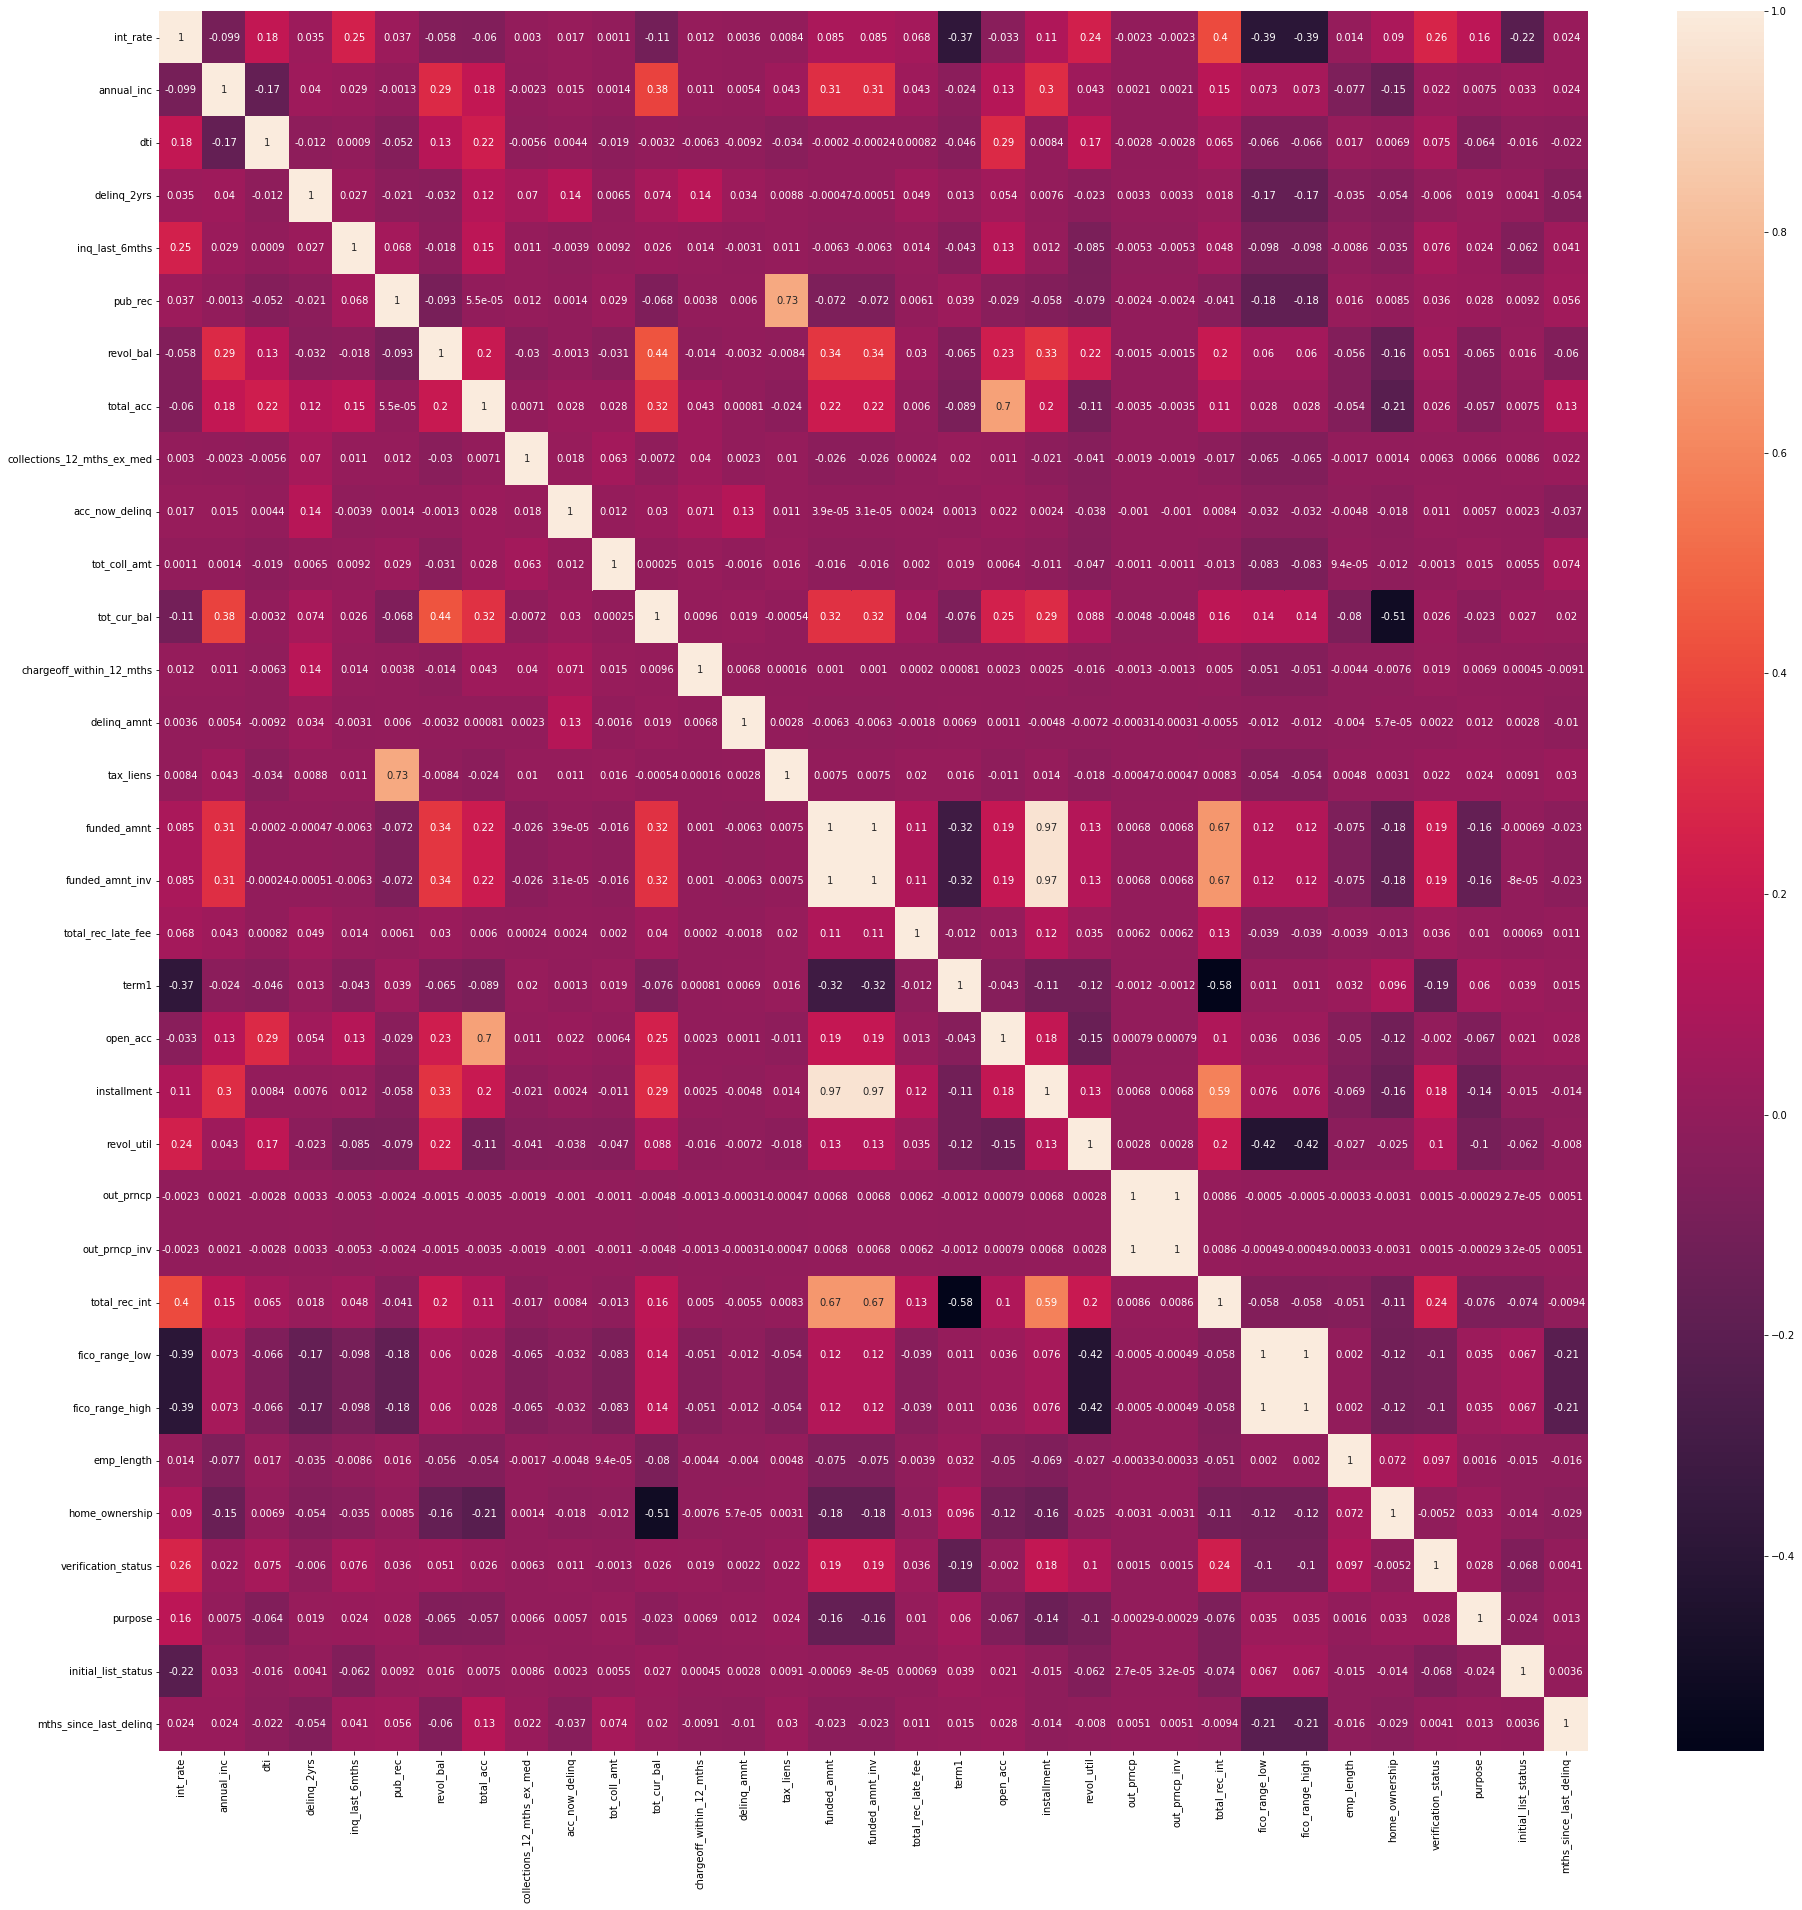

In [ ]:
corr_df = X_train.corr()

plt.figure(figsize=(32,32))
sns.heatmap(corr_df, annot = True)
plt.show()

'int_rate', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths',
       'pub_rec', 'revol_bal', 'total_acc', 'collections_12_mths_ex_med',
       'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal',
       'chargeoff_within_12_mths', 'delinq_amnt', 'tax_liens', 'funded_amnt',
       'funded_amnt_inv', 'total_rec_late_fee', 'term1', 'open_acc',
       'installment', 'revol_util', 'out_prncp', 'out_prncp_inv',
       'total_rec_int', 'fico_range_low', 'fico_range_high', 'emp_length',
       'home_ownership', 'verification_status', 'purpose',
       'initial_list_status', 'mths_since_last_delinq'

In [ ]:
vif = pd.DataFrame()
vif["VIF Factor"] =[variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif["features"] = X_train.columns
vif = vif.sort_values("VIF Factor").reset_index(drop=True)
vif

,VIF Factor,features
0,1.018898e+00,delinq_amnt
1,1.033092e+00,collections_12_mths_ex_med
2,1.036414e+00,chargeoff_within_12_mths
3,1.040035e+00,tot_coll_amt
4,1.049437e+00,acc_now_delinq
5,1.061281e+00,total_rec_late_fee
6,1.308766e+00,delinq_2yrs
7,1.715094e+00,inq_last_6mths
8,2.293237e+00,revol_bal
9,2.314858e+00,tax_liens


In [ ]:
y_train.value_counts()

0    53902
1    26098
Name: depvar, dtype: int64

In [ ]:
X.columns

Index(['int_rate', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths',
       'pub_rec', 'revol_bal', 'total_acc', 'collections_12_mths_ex_med',
       'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal',
       'chargeoff_within_12_mths', 'delinq_amnt', 'tax_liens', 'funded_amnt',
       'total_rec_late_fee', 'term1', 'open_acc', 'revol_util', 'out_prncp',
       'total_rec_int', 'fico_range_low', 'fico_range_high', 'emp_length',
       'home_ownership', 'verification_status', 'purpose',
       'initial_list_status', 'mths_since_last_delinq'],
      dtype='object')

In [ ]:
drop_columns = ['installment']
# 4개 뺏을때, Pseudo R-squ = 0.1267로 가장 높은 설명력을 지님
X_test = X.drop(columns = drop_columns, axis=1)

KeyError: ignored

In [ ]:
results.params

int_rate                      1.334665e+01
annual_inc                   -1.596629e-06
dti                           2.004411e-02
delinq_2yrs                   3.148924e-02
inq_last_6mths                9.160417e-02
pub_rec                       2.791281e-02
revol_bal                    -1.558528e-06
total_acc                    -8.343361e-03
collections_12_mths_ex_med    1.397346e-01
acc_now_delinq                2.355730e-02
tot_coll_amt                  4.254622e-06
tot_cur_bal                  -8.354826e-07
chargeoff_within_12_mths     -1.131379e-01
delinq_amnt                   1.499528e-05
tax_liens                    -1.144581e-02
funded_amnt                   6.233671e-05
total_rec_late_fee            3.311797e-02
term1                        -1.065256e+00
open_acc                      2.330878e-02
revol_util                   -1.040235e-01
out_prncp                     8.767583e-02
total_rec_int                -3.008292e-04
fico_range_low               -7.064540e-01
fico_range_

In [ ]:
np.exp(results.params)

int_rate                      625717.609252
annual_inc                         0.999998
dti                                1.020246
delinq_2yrs                        1.031990
inq_last_6mths                     1.095931
pub_rec                            1.028306
revol_bal                          0.999998
total_acc                          0.991691
collections_12_mths_ex_med         1.149969
acc_now_delinq                     1.023837
tot_coll_amt                       1.000004
tot_cur_bal                        0.999999
chargeoff_within_12_mths           0.893027
delinq_amnt                        1.000015
tax_liens                          0.988619
funded_amnt                        1.000062
total_rec_late_fee                 1.033672
term1                              0.344640
open_acc                           1.023583
revol_util                         0.901204
out_prncp                          1.091634
total_rec_int                      0.999699
fico_range_low                  

In [ ]:
def feature_engineering_XbyVIF(X_train, num_variables):
    vif = pd.DataFrame()
    vif['VIF_Factor'] = [variance_inflation_factor(X_train.values, i) 
                         for i in range(X_train.shape[1])]
    vif['Feature'] = X_train.columns
    X_colname_vif = vif.sort_values(by='VIF_Factor', ascending=True)['Feature'][:num_variables].values
    return X_colname_vif

In [ ]:
print(X_train.columns)


Index(['int_rate', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths',
       'pub_rec', 'revol_bal', 'total_acc', 'collections_12_mths_ex_med',
       'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal',
       'chargeoff_within_12_mths', 'delinq_amnt', 'tax_liens', 'funded_amnt',
       'total_rec_late_fee', 'term1', 'open_acc', 'revol_util', 'out_prncp',
       'total_rec_int', 'fico_range_low', 'fico_range_high', 'emp_length',
       'home_ownership', 'verification_status', 'purpose',
       'mths_since_last_delinq'],
      dtype='object')


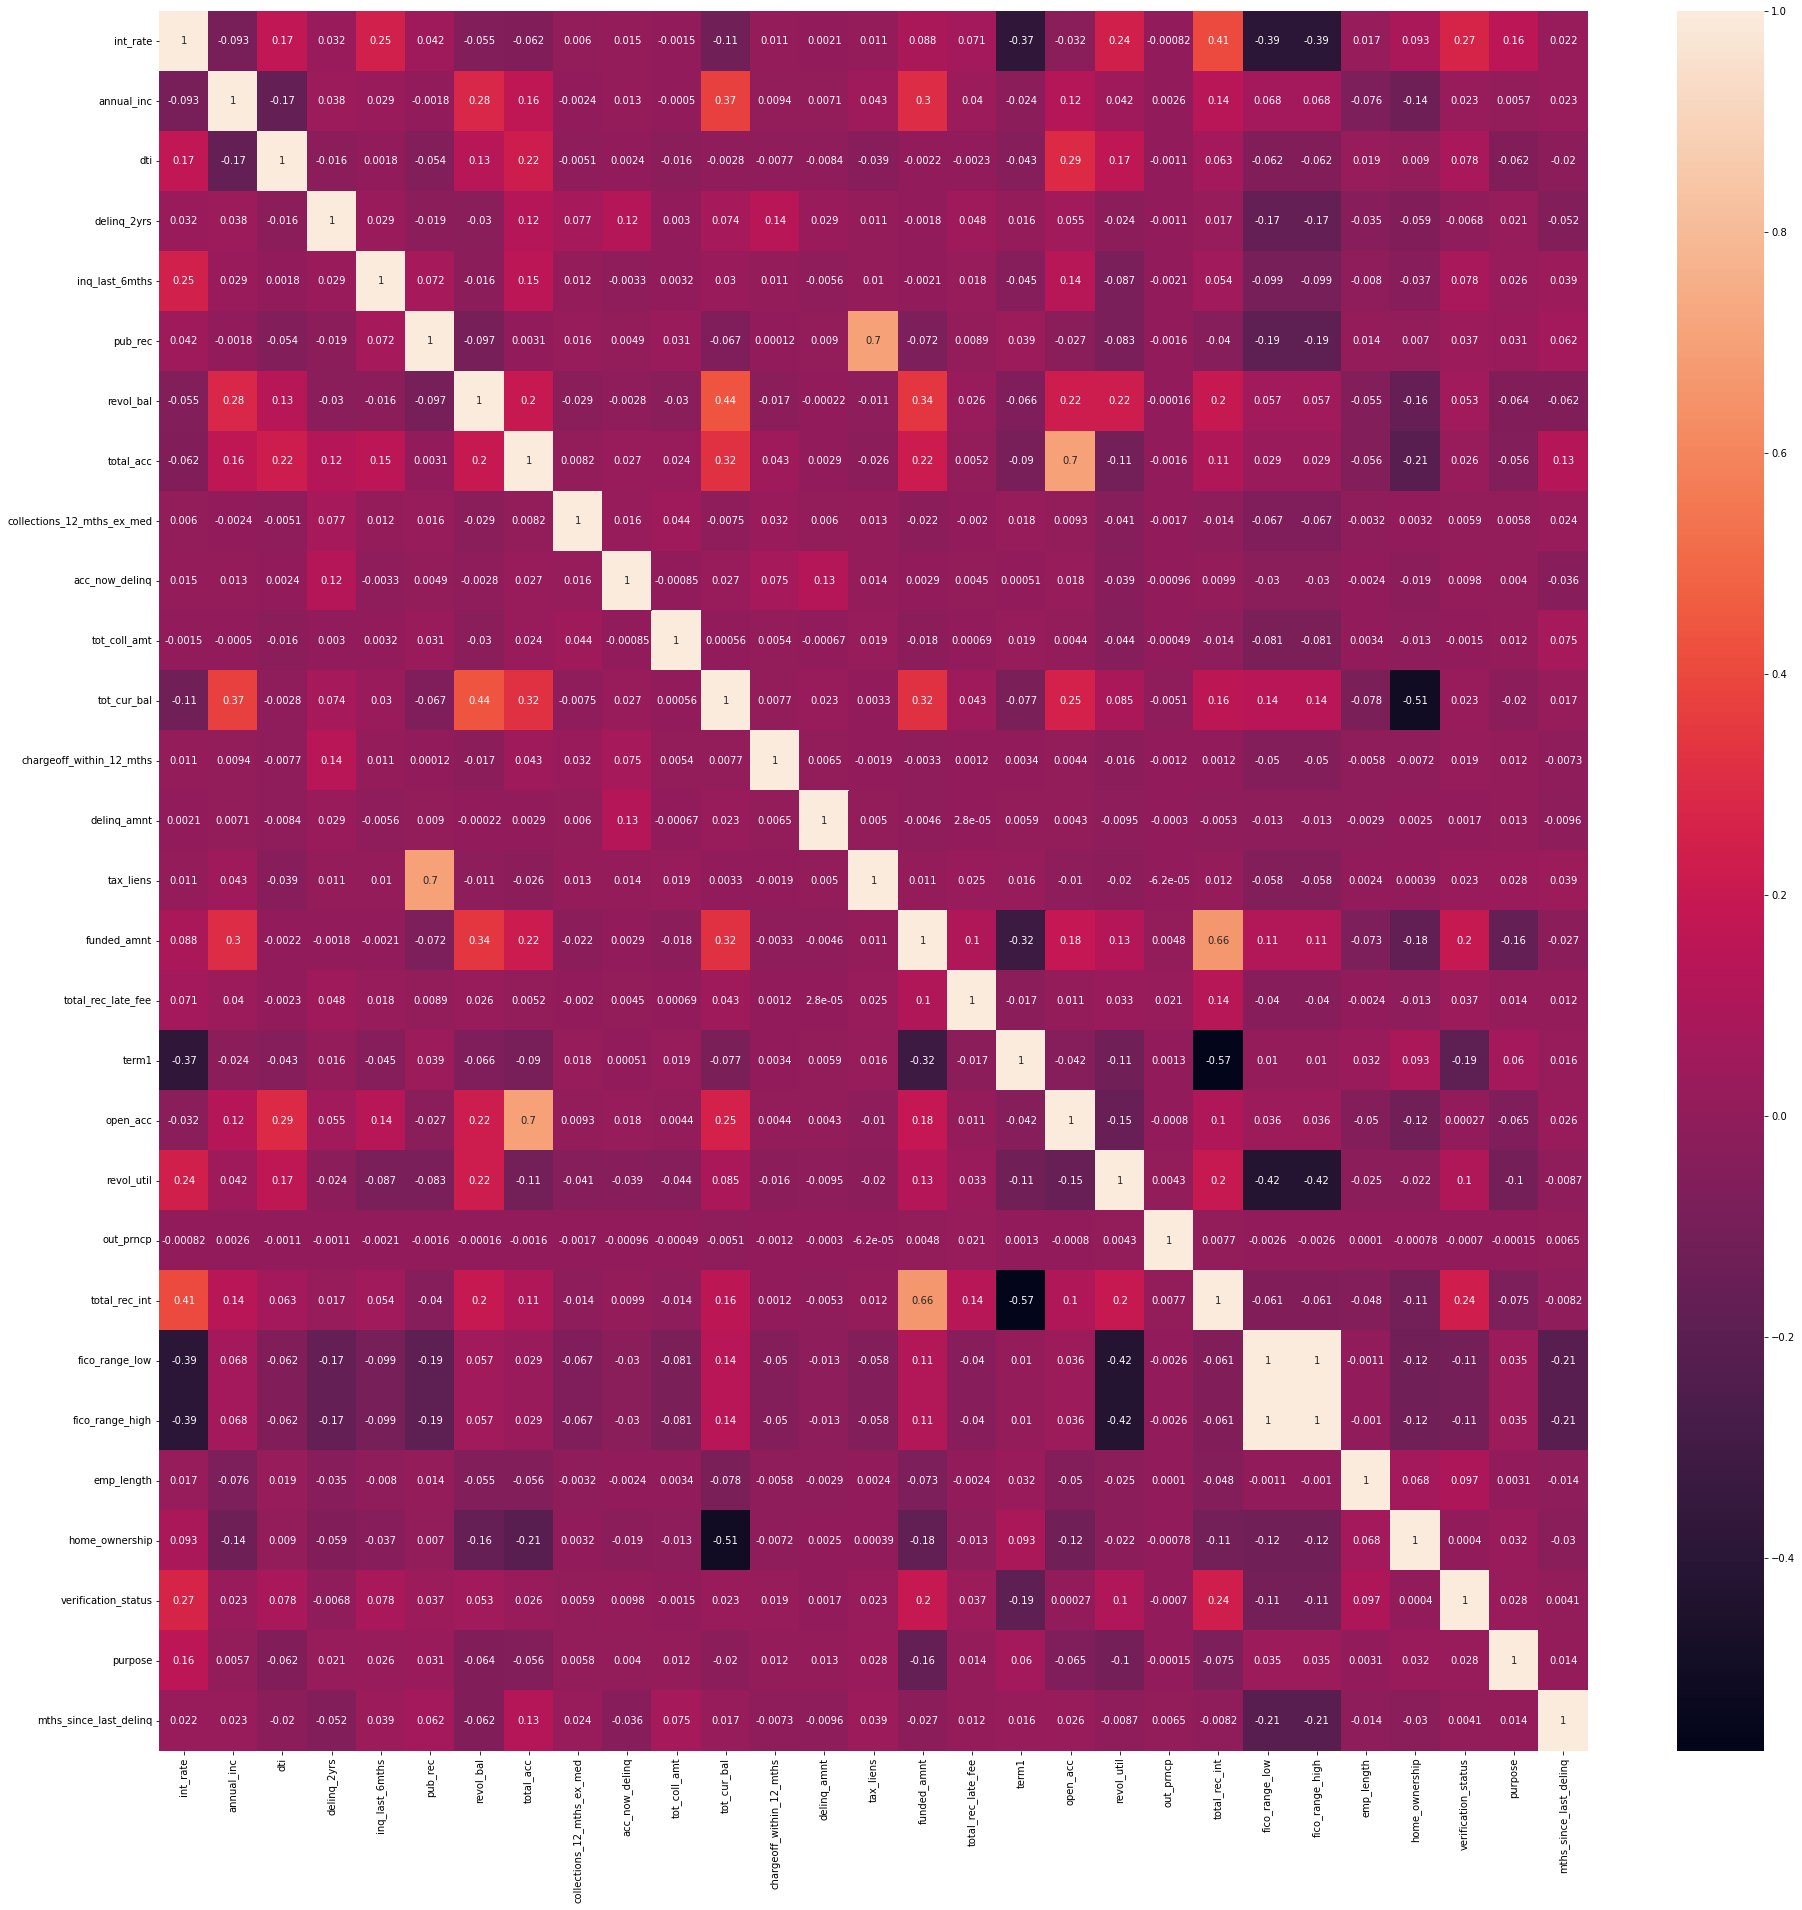

In [ ]:
corr_df = X_train.corr()

plt.figure(figsize=(32,32))
sns.heatmap(corr_df, annot = True)
plt.show()

# vif 분석


In [194]:
import statsmodels.api as sm

model = sm.Logit(y_train, X_train)
results = model.fit(method = "newton")
results

         Current function value: 0.551072
         Iterations: 35


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [195]:
results.summary()

# 의사-결정계수(pseudo-r^2)

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 depvar   No. Observations:                80000
Model:                          Logit   Df Residuals:                    79970
Method:                           MLE   Df Model:                           29
Date:                Fri, 04 Feb 2022   Pseudo R-squ.:                  0.1271
Time:                        14:12:47   Log-Likelihood:                -44086.
converged:                      False   LL-Null:                       -50503.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
int_rate                      13.8754      0.261     53.073      0.000      13.363      14.388
annual_inc                 -1.755e-06   2.68e-07     -6.553      0.000   -2.28e-06   -1.23e-06
dti                            0.0192      0.001     16.895      0.000       0.017       0.021
delinq_2yrs                    0.0285      0.009      3.030      0.002       0.010       0.047
inq_last_6mths                 0.0795      0.009      8.866      0.000       0.062       0.097
pub_rec                        0.0395      0.019      2.109      0.035       0.003       0.076
revol_bal                  -1.449e-06   5.88e-07     -2.462      0.014    -2.6e-06   -2.96e-07
total_acc                     -0.0090      0.001     -8.535      0.000      -0.011      -0.007
collections_12_mths_ex_med     0.1716      0.052      3.296      0.001       0.070       0.274
acc_now_delinq                -0.0420      0.096     -0.439      0.661      -0.229       0.146
tot_coll_amt                2.771e-06   3.86e-06      0.718      0.472   -4.79e-06    1.03e-05
tot_cur_bal                -8.712e-07   8.91e-08     -9.782      0.000   -1.05e-06   -6.97e-07
chargeoff_within_12_mths      -0.0660      0.073     -0.904      0.366      -0.209       0.077
delinq_amnt                 1.548e-05   8.78e-06      1.763      0.078   -1.73e-06    3.27e-05
tax_liens                     -0.0249      0.025     -0.984      0.325      -0.074       0.025
funded_amnt                 6.359e-05   1.62e-06     39.257      0.000    6.04e-05    6.68e-05
total_rec_late_fee             0.0324      0.001     35.561      0.000       0.031       0.034
term1                         -1.0622      0.030    -35.970      0.000      -1.120      -1.004
open_acc                       0.0244      0.002     10.842      0.000       0.020       0.029
revol_util                    -0.1228      0.044     -2.762      0.006      -0.210      -0.036
out_prncp                      0.5021   8656.307    5.8e-05      1.000    -1.7e+04     1.7e+04
total_rec_int                 -0.0003   5.79e-06    -53.310      0.000      -0.000      -0.000
fico_range_low                -0.6586      0.079     -8.329      0.000      -0.814      -0.504
fico_range_high                0.6513      0.079      8.279      0.000       0.497       0.806
emp_length                     0.0202      0.002      8.706      0.000       0.016       0.025
home_ownership                 0.0346      0.005      6.677      0.000       0.024       0.045
verification_status            0.0494      0.011      4.436      0.000       0.028       0.071
purpose                        0.0009      0.004      0.252      0.801      -0.006       0.008
initial_list_status            0.0235      0.017      1.381      0.167      -0.010       0.057
mths_since_last_delinq        -0.0001      0.003     -0.051      0.959      -0.005       0.005
==============================================================================================
"""

In [196]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif["VIF Factor"] =[variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif["features"] = X_train.columns
vif = vif.sort_values("VIF Factor").reset_index(drop=True)
vif

,VIF Factor,features
0,1.000410e+00,out_prncp
1,1.015506e+00,delinq_amnt
2,1.034041e+00,collections_12_mths_ex_med
3,1.036433e+00,chargeoff_within_12_mths
4,1.036499e+00,tot_coll_amt
5,1.045412e+00,acc_now_delinq
6,1.058596e+00,total_rec_late_fee
7,1.303331e+00,delinq_2yrs
8,1.716557e+00,inq_last_6mths
9,2.282943e+00,revol_bal


# OverSampling - SMOTE-ADASYN

In [ ]:
from imblearn.over_sampling import ADASYN

adasyn = ADASYN(random_state=22)
X_train_ad, y_train_ad = adasyn.fit_resample(X_train, y_train)
print('training set length :', len(X_train_ad))
print('1 ratio : ', y_train_ad.sum()/len(y_train_ad))

# 비슷한 비율로 만듦

training set length : 107993
1 ratio :  0.5003287250099544


In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=22)
X_train_ad, y_train_ad = smote.fit_resample(X_train, y_train)
print('training set length :', len(X_train_ad))
print('1 ratio : ', y_train_ad.sum()/len(y_train_ad))

# 비슷한 비율로 만듦

training set length : 107948
1 ratio :  0.5


In [ ]:
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks

smoteto = SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))
X_train_ad, y_train_ad = smoteto.fit_resample(X_train, y_train)

In [ ]:
y_train.value_counts()

0    53866
1    26134
Name: depvar, dtype: int64

In [ ]:
y_train_ad.value_counts()

1    53866
0    49834
Name: depvar, dtype: int64

# Model Training


In [ ]:
# threshold 변경 및 성능 확인 할 수 있는 방법 : 모델.predict_proba -> (0이나올확률, 1이나올확률) 
# for i in [0.4, 0.45, 0.55, 0.6] :
#   print(f'threshold : {i}')
#   get_clf_eval(y_valid, y_pred_prob[:,1]> i)

# Ensemble(Voting)

In [ ]:

# # rnd_clf  = RandomForestClassifier()
# # lgbm_clf = LGBMClassifier()
# # rid_clf = RidgeClassifier()
# # dtc_clf = DecisionTreeClassifier()
# # svm_clf = SVC()
# # ada_clf = AdaBoostClassifier()
# # gbc_clf = GradientBoostingClassifier()
# # bag_clf = BaggingClassifier()
# # ext_clf = ExtraTreesClassifier()
# # knn_clf = KNeighborsClassifier()
# # svc_clf = SVC()

# rnd_clf = RandomForestClassifier(max_depth = 20)
# xgb_clf = xgboost.XGBClassifier(max_depth = 6,
#                                 n_estimators = 100,
#                                 eval_metric='mlogloss')
# lgbm_clf = LGBMClassifier(max_depth=15,
#                                   num_leaves =150)


# voting_clf = VotingClassifier(estimators=[('rnd', rnd_clf), ('lgbm', lgbm_clf), ('xgb', xgb_clf)], voting='soft')

In [ ]:
# for clf in (rnd_clf, lgbm_clf, xgb_clf) :
#     clf.fit(X_train, y_train)
#     y_pred_vote = clf.predict(X_valid)

# # ensemble(voting) 성능 확인
# get_clf_eval(y_valid, y_pred_vote)

In [ ]:
xgb_clf = xgboost.XGBClassifier()

param_grid = {'max_depth' : [9, 12 ,15],
              'n_estimators' : [150, 200, 250]}

cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=2)

grid_search = GridSearchCV(estimator=xgb_clf,
                           param_grid=param_grid, 
                           n_jobs=-1,
                           cv=cv,
                           scoring='f1', 
                           error_score=0) 

results=grid_search.fit(X_train, y_train)

results.best_params_

{'max_depth': 9, 'n_estimators': 250}

In [ ]:
rnd_clf = RandomForestClassifier()

param_grid = {'max_depth' : [5, 8, 10, 15, 18, 20]}

cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=2)

grid_search = GridSearchCV(estimator=rnd_clf,
                           param_grid=param_grid, 
                           n_jobs=-1,
                           cv=cv,
                           scoring='f1', 
                           error_score=0) 

results=grid_search.fit(X_train_ad, y_train_ad)

results.best_params_

In [ ]:
lgbm_clf = LGBMClassifier()


param_grid = {'max_depth' : [20, 23, 25],
              'num_leaves'  :[120, 130, 135, 140]}

cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=2)

grid_search = GridSearchCV(estimator=lgbm_clf,
                           param_grid=param_grid, 
                           n_jobs=-1,
                           cv=cv,
                           scoring='f1', 
                           error_score=0) 

results=grid_search.fit(X_train, y_train)

results.best_params_

{'max_depth': 25, 'num_leaves': 140}

# Ensemble(Stacking) - 새로운 파라미터 도전

In [ ]:
rnd_clf = RandomForestClassifier(max_depth = 20)
xgb_clf = xgboost.XGBClassifier(max_depth = 6,
                                n_estimators = 100,
                                eval_metric='merror')
lgbm_clf = LGBMClassifier(max_depth=10,
                          num_leaves =120,
                          learning_rate=0.01,
                          num_iterations=1000,
                          boosting = 'dart')


stacking_clf = StackingClassifier(estimators=[('rnd', rnd_clf),('lgbm', lgbm_clf), ('xgb', xgb_clf)], final_estimator = LGBMClassifier(), stack_method = 'predict_proba')
stacking_clf.fit(X_train_ad, y_train_ad)

y_pred_stack = stacking_clf.predict(X_valid)
y_pred_prob = stacking_clf.predict_proba(X_valid)

# ensemble(stacking) 성능 확인
get_clf_eval(y_valid, y_pred_stack)

####### 교차 검증 ########## : 1

정확도: 0.7535
정밀도: 0.6543
재현율: 0.5153
AUC: 0.6919
F1: 0.5765
교차 검증 정확도 : None
####### 교차 검증 ########## : 2

정확도: 0.7572
정밀도: 0.6649
재현율: 0.5130
AUC: 0.6941
F1: 0.5792
교차 검증 정확도 : None
####### 교차 검증 ########## : 3

정확도: 0.7536
정밀도: 0.6660
재현율: 0.4883
AUC: 0.6850
F1: 0.5635
교차 검증 정확도 : None
####### 교차 검증 ########## : 4

정확도: 0.7553
정밀도: 0.6537
재현율: 0.5292
AUC: 0.6969
F1: 0.5849
교차 검증 정확도 : None
####### 교차 검증 ########## : 5

정확도: 0.7556
정밀도: 0.6562
재현율: 0.5239
AUC: 0.6957
F1: 0.5827
교차 검증 정확도 : None


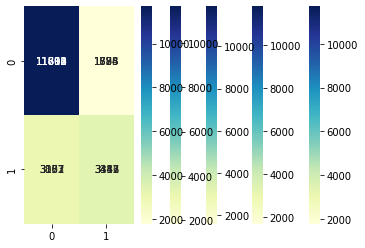

In [ ]:
from sklearn.model_selection import StratifiedKFold

rnd_clf = RandomForestClassifier(max_depth = 20)
xgb_clf = xgboost.XGBClassifier(max_depth = 6,
                                n_estimators = 100,
                                eval_metric='mlogloss')
lgbm_clf = LGBMClassifier(max_depth=10,
                                  num_leaves =120)


stacking_clf = StackingClassifier(estimators=[('rnd', rnd_clf),('lgbm', lgbm_clf), ('xgb', xgb_clf)], final_estimator = LGBMClassifier(), stack_method = 'predict_proba')


skf = StratifiedKFold(n_splits=5)
n_iter = 0

dict ={}

X = X.values
y = y.values

for train_index, test_index in skf.split(df, df['depvar']):
  n_iter += 1
  stacking_clf = StackingClassifier(estimators=[('rnd', rnd_clf),('lgbm', lgbm_clf), ('xgb', xgb_clf)], final_estimator = LGBMClassifier(), stack_method = 'predict_proba')
  label_train = df['depvar'].iloc[train_index]
  label_test = df['depvar'].iloc[test_index]
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]

  stacking_clf.fit(X_train, y_train)

  y_pred_prob = stacking_clf.predict_proba(X_test)

  dict[n_iter] = y_pred_prob





# 0.4일 때가 0.38때보다 더 높은 점수를 획득할 수 있었다... 0.42일때는 어떨까...?

threshold : 0.4

정확도: 0.7447
정밀도: 0.5928
재현율: 0.6586
AUC: 0.7221
F1: 0.6240
threshold : 0.41

정확도: 0.7465
정밀도: 0.5968
재현율: 0.6533
AUC: 0.7220
F1: 0.6238
threshold : 0.42

정확도: 0.7482
정밀도: 0.6013
재현율: 0.6446
AUC: 0.7210
F1: 0.6222
threshold : 0.43

정확도: 0.7499
정밀도: 0.6068
재현율: 0.6321
AUC: 0.7189
F1: 0.6192
threshold : 0.45

정확도: 0.7533
정밀도: 0.6188
재현율: 0.6072
AUC: 0.7149
F1: 0.6129
threshold : 0.48

정확도: 0.7564
정밀도: 0.6410
재현율: 0.5517
AUC: 0.7026
F1: 0.5930
threshold : 0.5

정확도: 0.7571
정밀도: 0.6562
재현율: 0.5144
AUC: 0.6933
F1: 0.5767
threshold : 0.52

정확도: 0.7566
정밀도: 0.6671
재현율: 0.4856
AUC: 0.6854
F1: 0.5621
threshold : 0.54

정확도: 0.7574
정밀도: 0.6806
재현율: 0.4634
AUC: 0.6801
F1: 0.5514


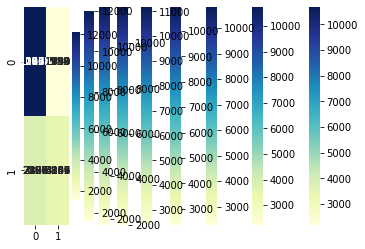

In [ ]:
for i in [0.4, 0.41, 0.42, 0.43, 0.45, 0.48 , 0.5, 0.52, 0.54] :
  print(f'threshold : {i}')
  get_clf_eval(y_valid, y_pred_prob[:,1]>i) 

threshold : 0.38

정확도: 0.7380
정밀도: 0.5781
재현율: 0.7038
AUC: 0.7291
F1: 0.6348
threshold : 0.4

정확도: 0.7424
정밀도: 0.5874
재현율: 0.6851
AUC: 0.7274
F1: 0.6325
threshold : 0.41

정확도: 0.7446
정밀도: 0.5931
재현율: 0.6702
AUC: 0.7252
F1: 0.6293
threshold : 0.42

정확도: 0.7474
정밀도: 0.6006
재현율: 0.6549
AUC: 0.7233
F1: 0.6266
threshold : 0.43

정확도: 0.7482
정밀도: 0.6050
재현율: 0.6392
AUC: 0.7198
F1: 0.6216
threshold : 0.45

정확도: 0.7538
정밀도: 0.6299
재현율: 0.5797
AUC: 0.7084
F1: 0.6037
threshold : 0.48

정확도: 0.7537
정밀도: 0.6493
재현율: 0.5189
AUC: 0.6924
F1: 0.5768


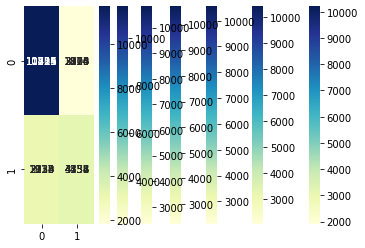

In [ ]:
for i in [0.38, 0.4, 0.41, 0.42, 0.43, 0.45, 0.48] :
  print(f'threshold : {i}')
  get_clf_eval(y_valid, y_pred_prob[:,1]>i) 

# 정확도: 0.7537
# 정밀도: 0.6593
# 재현율: 0.4941
# AUC: 0.6860
# F1: 0.5648

# 정확도: 0.7541
# 정밀도: 0.6603
# 재현율: 0.4942
# AUC: 0.6863
# F1: 0.5653

# 정확도: 0.7579
# 정밀도: 0.6664
# 재현율: 0.5059
# AUC: 0.6923
# F1: 0.5752

# CV기반 stacking

In [ ]:
from sklearn.model_selection import KFold, StratifiedKFold

def get_stacking_data(model, X_train, y_train, X_test, n_folds=5):
  stk = StratifiedKFold(n_splits =n_folds)
  # 최종 모델에서 사용할 데이터 셋 셋팅(0값으로)
  # 만약 shape가 (100,10) 이었다면 폴드의 검증 과정에서 저장할 데이터는 (100,1) 모양을 갖게 한다.
  train_fold_predict = np.zeros((X_train.shape[0], 1))
  # test는 X_test값을 이용해서 매 폴드마다 예측을 하기 때문에 (데이터의수, fold개수) 만큼의 shape을 갖게 된다.
  # 그래서 해당 폴드마다 X_test의 예측 값을 해당 fold에 해당되는 열에 넣는다.
  test_predict = np.zeros((X_test.shape[0], n_folds))


  for cnt, (train_index, valid_index) in enumerate(stk.split(X_train, y_train)):
    X_train_ , X_validation =  X_train.iloc[train_index, :], X_train.iloc[valid_index, :]
    y_train_ = y_train.iloc[train_index]
   

    model.fit(X_train_, y_train_)

    train_fold_predict[valid_index, :] = model.predict(X_validation).reshape(-1,1)
  test_predict[:, cnt] = model.predict(X_test)
  test_predict_mean = np.mean(test_predict, axis=1).reshape(-1,1)
  return  train_fold_predict, test_predict_mean


In [248]:
# proba test 코드

from sklearn.model_selection import KFold, StratifiedKFold

def get_stacking_data(model, X_train, y_train, X_test, n_folds=5):
  stk = StratifiedKFold(n_splits =n_folds)
  # 최종 모델에서 사용할 데이터 셋 셋팅(0값으로)
  # 만약 shape가 (100,10) 이었다면 폴드의 검증 과정에서 저장할 데이터는 (100,2) 모양을 갖게 한다.
  train_fold_predict_proba = np.zeros((X_train.shape[0], 2))
  # test는 X_test값을 이용해서 매 폴드마다 예측을 하기 때문에 (fold개수, 데이터의수, 2) 만큼의 shape을 갖게 된다.
  # 그래서 해당 폴드마다 X_test의 예측 값을 해당 fold에 해당되는 열에 넣는다.
  test_predict_proba = np.zeros((n_folds,X_test.shape[0],2))


  for cnt, (train_index, valid_index) in enumerate(stk.split(X_train, y_train)):
    X_train_ , X_validation =  X_train.iloc[train_index, :], X_train.iloc[valid_index, :]
    y_train_ = y_train.iloc[train_index]
   

    model.fit(X_train_, y_train_)

    train_fold_predict_proba[valid_index, :] = model.predict_proba(X_validation)
  test_predict_proba[cnt] = model.predict_proba(X_test)  # fold별로저장
  test_predict_mean = np.mean(test_predict_proba, axis=0)
  return  train_fold_predict_proba, test_predict_mean

In [260]:
a = np.ones((5,50,2))
a[0] =2 
a

array([[[2., 2.],
        [2., 2.],
        [2., 2.],
        [2., 2.],
        [2., 2.],
        [2., 2.],
        [2., 2.],
        [2., 2.],
        [2., 2.],
        [2., 2.],
        [2., 2.],
        [2., 2.],
        [2., 2.],
        [2., 2.],
        [2., 2.],
        [2., 2.],
        [2., 2.],
        [2., 2.],
        [2., 2.],
        [2., 2.],
        [2., 2.],
        [2., 2.],
        [2., 2.],
        [2., 2.],
        [2., 2.],
        [2., 2.],
        [2., 2.],
        [2., 2.],
        [2., 2.],
        [2., 2.],
        [2., 2.],
        [2., 2.],
        [2., 2.],
        [2., 2.],
        [2., 2.],
        [2., 2.],
        [2., 2.],
        [2., 2.],
        [2., 2.],
        [2., 2.],
        [2., 2.],
        [2., 2.],
        [2., 2.],
        [2., 2.],
        [2., 2.],
        [2., 2.],
        [2., 2.],
        [2., 2.],
        [2., 2.],
        [2., 2.]],

       [[1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        

In [ ]:
# 확인용
stk = StratifiedKFold(n_splits =5)
for cnt, (train_index, valid_index) in enumerate(stk.split(X_train, y_train)):
    X_train_ = X_train.iloc[train_index, :]
    y_train_ = y_train.iloc[train_index]
    print(y_train)

5032     0
8917     0
96290    0
9130     0
90012    0
        ..
77794    1
53180    0
42196    0
37626    1
27753    1
Name: depvar, Length: 80000, dtype: int64
5032     0
8917     0
96290    0
9130     0
90012    0
        ..
77794    1
53180    0
42196    0
37626    1
27753    1
Name: depvar, Length: 80000, dtype: int64
5032     0
8917     0
96290    0
9130     0
90012    0
        ..
77794    1
53180    0
42196    0
37626    1
27753    1
Name: depvar, Length: 80000, dtype: int64
5032     0
8917     0
96290    0
9130     0
90012    0
        ..
77794    1
53180    0
42196    0
37626    1
27753    1
Name: depvar, Length: 80000, dtype: int64
5032     0
8917     0
96290    0
9130     0
90012    0
        ..
77794    1
53180    0
42196    0
37626    1
27753    1
Name: depvar, Length: 80000, dtype: int64


In [198]:
rnd_clf = RandomForestClassifier(max_depth = 20)
xgb_clf = xgboost.XGBClassifier(max_depth = 6,
                                n_estimators = 100,
                                eval_metric='mlogloss')
lgbm_clf = LGBMClassifier(max_depth=10,
                                  num_leaves =120)

In [200]:
rnd_train, rnd_test = get_stacking_data(rnd_clf, X_train, y_train, X_test)
xgb_train, xgb_test = get_stacking_data(xgb_clf, X_train, y_train, X_test) 
lgbm_train, lgbm_test = get_stacking_data(lgbm_clf, X_train, y_train, X_test)


In [247]:
rnd_train

array([[0.63782185, 0.36217815],
       [0.88190522, 0.11809478],
       [0.56058749, 0.43941251],
       ...,
       [0.68226456, 0.31773544],
       [0.92155143, 0.07844857],
       [0.90736407, 0.09263593]])

In [243]:
stack_prob = np.mean((rnd_test, xgb_test, lgbm_test), axis = 0)

In [245]:
stack_prob[:20]

array([[0.1034165 , 0.0965835 ],
       [0.10642465, 0.09357535],
       [0.16679944, 0.03320056],
       [0.08402784, 0.11597216],
       [0.11437084, 0.08562916],
       [0.13161221, 0.06838779],
       [0.04813297, 0.15186703],
       [0.15648177, 0.04351823],
       [0.15906049, 0.04093952],
       [0.16860104, 0.03139896],
       [0.08929638, 0.11070362],
       [0.14450947, 0.05549053],
       [0.16818225, 0.03181775],
       [0.16723036, 0.03276965],
       [0.08003631, 0.11996369],
       [0.15615834, 0.04384166],
       [0.16979632, 0.03020368],
       [0.06862446, 0.13137554],
       [0.12091771, 0.07908229],
       [0.09683265, 0.10316735]])

In [225]:
new_X_train = np.concatenate((rnd_train, xgb_train, lgbm_train), axis = 1)
new_X_test = np.concatenate((rnd_test, xgb_test, lgbm_test), axis = 1)

In [226]:
print("원본 : ", X_train.shape, X_test.shape)
print("새로운 : ", new_X_train.shape, new_X_train.shape)

원본 :  (80000, 30) (20000, 30)
새로운 :  (80000, 6) (80000, 6)


In [227]:
new_X_train

array([[0.63782185, 0.36217815, 0.58783531, 0.41216469, 0.57662105,
        0.42337895],
       [0.88190522, 0.11809478, 0.93889672, 0.06110328, 0.93835356,
        0.06164644],
       [0.56058749, 0.43941251, 0.45064628, 0.54935372, 0.41871414,
        0.58128586],
       ...,
       [0.68226456, 0.31773544, 0.78406632, 0.21593368, 0.86544728,
        0.13455272],
       [0.92155143, 0.07844857, 0.93448788, 0.06551211, 0.93298395,
        0.06701605],
       [0.90736407, 0.09263593, 0.86742139, 0.13257861, 0.92490575,
        0.07509425]])


정확도: 0.3246
정밀도: 0.3246
재현율: 1.0000
AUC: 0.5000
F1: 0.4901


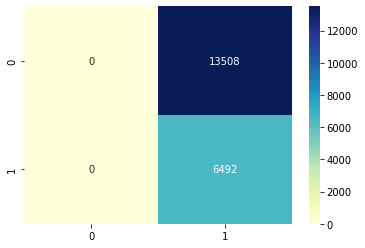

In [229]:
final_lgbm_clf = RandomForestClassifier()

final_lgbm_clf.fit(new_X_train, y_train)
stack_pred = final_lgbm_clf.predict(new_X_test)
stack_prob = final_lgbm_clf.predict_proba(new_X_test)

get_clf_eval(y_test, stack_pred)

In [239]:
from numpy import sqrt
from numpy import argmax
from sklearn.metrics import classification_report
from sklearn.metrics import plot_roc_curve



y_prob2 = stack_prob[:,1]


fpr, tpr, thresholds = roc_curve(y_test, y_prob2)
# get the best threshold
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold=%f, sensitivity = %.3f, specificity = %.3f, J=%.3f' % (best_thresh, tpr[ix], 1-fpr[ix], J[ix]))

y_prob_pred = (stack_prob[:,1] >= best_thresh).astype(bool)
print(classification_report(y_test, y_prob_pred, target_names=['normal', 'abnormal']))


Best Threshold=0.066173, sensitivity = 0.702, specificity = 0.739, J=0.441
              precision    recall  f1-score   support

      normal       0.84      0.74      0.78     13508
    abnormal       0.56      0.70      0.63      6492

    accuracy                           0.73     20000
   macro avg       0.70      0.72      0.71     20000
weighted avg       0.75      0.73      0.73     20000




정확도: 0.6754
정밀도: 0.0000
재현율: 0.0000
AUC: 0.5000
F1: 0.0000


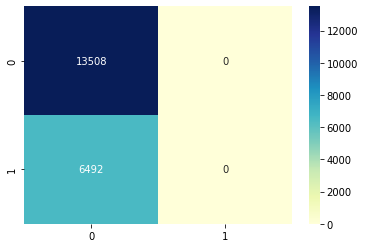

In [242]:
get_clf_eval(y_test, stack_prob[:,1]>0.5)

threshold : 0.3

정확도: 0.8121
정밀도: 0.6430
재현율: 0.9433
AUC: 0.8463
F1: 0.7647
threshold : 0.35

정확도: 0.8419
정밀도: 0.6874
재현율: 0.9385
AUC: 0.8671
F1: 0.7936
threshold : 0.38

정확도: 0.8419
정밀도: 0.6874
재현율: 0.9385
AUC: 0.8671
F1: 0.7936
threshold : 0.4

정확도: 0.8419
정밀도: 0.6874
재현율: 0.9385
AUC: 0.8671
F1: 0.7936
threshold : 0.42

정확도: 0.8419
정밀도: 0.6874
재현율: 0.9385
AUC: 0.8671
F1: 0.7936
threshold : 0.45

정확도: 0.8419
정밀도: 0.6874
재현율: 0.9385
AUC: 0.8671
F1: 0.7936


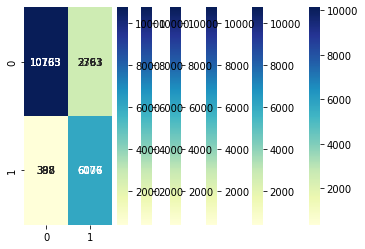

In [ ]:
for i in [0.3, 0.35, 0.38, 0.4, 0.42, 0.45] :
  print(f'threshold : {i}')
  get_clf_eval(y_test, stack_prob[:,1]>i) # 0.5, 0.6, # 0.3 # 0.2 # 0.1

# 기존모델


정확도: 0.7567
정밀도: 0.6535
재현율: 0.4983
AUC: 0.6876
F1: 0.5655


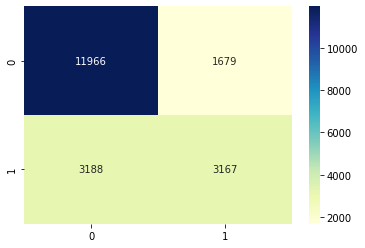

In [ ]:
rnd_clf = RandomForestClassifier(max_depth = 20)
xgb_clf = xgboost.XGBClassifier(max_depth = 6,
                                n_estimators = 100,
                                eval_metric='mlogloss')
lgbm_clf = LGBMClassifier(max_depth=15,
                                  num_leaves =150)


stacking_clf = StackingClassifier(estimators=[('lgbm', lgbm_clf), ('xgb', xgb_clf)], final_estimator = xgboost.XGBClassifier())
stacking_clf.fit(X_train, y_train)

y_pred_stack = stacking_clf.predict(X_valid)
y_pred_prob = stacking_clf.predict_proba(X_valid)

# ensemble(stacking) 성능 확인
get_clf_eval(y_valid, y_pred_stack)

In [ ]:
# y_pred_prob = stacking_clf.predict_proba(X_valid)
y_pred_prob[:,1] > 0.4 

# 출력값은 true, false 형태이다.

array([ True,  True,  True, ..., False, False, False])

threshold : 0.3

정확도: 0.7063
정밀도: 0.5253
재현율: 0.7841
AUC: 0.7270
F1: 0.6291
threshold : 0.35

정확도: 0.7251
정밀도: 0.5507
재현율: 0.7327
AUC: 0.7272
F1: 0.6288
threshold : 0.38

정확도: 0.7371
정밀도: 0.5722
재현율: 0.6842
AUC: 0.7230
F1: 0.6232
threshold : 0.4

정확도: 0.7440
정밀도: 0.5873
재현율: 0.6529
AUC: 0.7196
F1: 0.6184
threshold : 0.42

정확도: 0.7503
정밀도: 0.6068
재현율: 0.6088
AUC: 0.7125
F1: 0.6078
threshold : 0.45

정확도: 0.7518
정밀도: 0.6168
재현율: 0.5777
AUC: 0.7052
F1: 0.5966


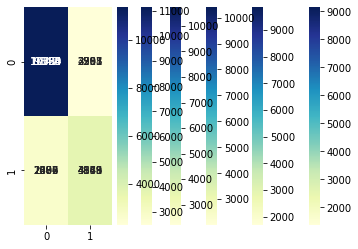

In [ ]:
for i in [0.3, 0.35, 0.38, 0.4, 0.42, 0.45] :
  print(f'threshold : {i}')
  get_clf_eval(y_valid, y_pred_prob[:,1]>i) # 0.5, 0.6, # 0.3 # 0.2 # 0.1

# threshold > 0.4  -> 1예측값에 시도

# 정확도: 0.7440
# 정밀도: 0.5873
# 재현율: 0.6529
# AUC: 0.7196
# F1: 0.6184

# threshold < 0.7  -> 0 예측값의 시도
# 정확도: 0.7427
# 정밀도: 0.5858
# 재현율: 0.6809
# AUC: 0.7264
# F1: 0.6298

# 데이터 불균형때문에 더 중요한 점수가 있을 것 같다.

threshold : 0.4

정확도: 0.7492
정밀도: 0.7138
재현율: 0.3667
AUC: 0.6485
F1: 0.4845
threshold : 0.5

정확도: 0.7561
정밀도: 0.6529
재현율: 0.5152
AUC: 0.6927
F1: 0.5759
threshold : 0.6

정확도: 0.7427
정밀도: 0.5858
재현율: 0.6809
AUC: 0.7264
F1: 0.6298
threshold : 0.7

정확도: 0.7109
정밀도: 0.5341
재현율: 0.7876
AUC: 0.7311
F1: 0.6365


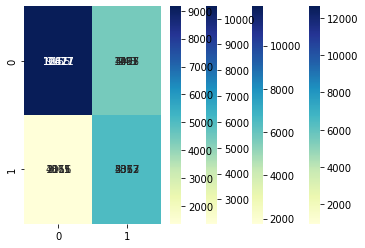

In [ ]:
for i in [0.4, 0.5, 0.6, 0.7 ] :
  print(f'threshold : {i}')
  get_clf_eval(y_valid, y_pred_prob[:,0]<i) # 0.5, 0.6, # 0.3 # 0.2 # 0.1

In [ ]:
X_train.columns

Index(['int_rate', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths',
       'pub_rec', 'revol_bal', 'total_acc', 'collections_12_mths_ex_med',
       'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal',
       'chargeoff_within_12_mths', 'delinq_amnt', 'tax_liens', 'funded_amnt',
       'total_rec_late_fee', 'term1', 'open_acc', 'revol_util', 'out_prncp',
       'total_rec_int', 'fico_range_low', 'fico_range_high', 'emp_length',
       'home_ownership', 'verification_status', 'purpose',
       'initial_list_status', 'mths_since_last_delinq'],
      dtype='object')

# 결과 출력

In [231]:

submit = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/20220126_DAY27(1주차 모의경진대회)/sample_submission.csv')

# prediction 수행
df_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/20220126_DAY27(1주차 모의경진대회)/test.csv')

In [232]:
df_test['emp_length2'] = df_test['emp_length2'].replace([1],2)
df_test['emp_length3'] = df_test['emp_length3'].replace([1],3)
df_test['emp_length4'] = df_test['emp_length4'].replace([1],4)
df_test['emp_length5'] = df_test['emp_length5'].replace([1],5)
df_test['emp_length6'] = df_test['emp_length6'].replace([1],6)
df_test['emp_length7'] = df_test['emp_length7'].replace([1],7)
df_test['emp_length8'] = df_test['emp_length8'].replace([1],8)
df_test['emp_length9'] = df_test['emp_length9'].replace([1],9)
df_test['emp_length10'] = df_test['emp_length10'].replace([1],10)
df_test['emp_length11'] = df_test['emp_length11'].replace([1],11)
df_test['emp_length12'] = df_test['emp_length12'].replace([1],12)

drop_columns = ['emp_length1','emp_length2','emp_length3','emp_length4','emp_length5','emp_length6','emp_length7','emp_length8','emp_length9', 'emp_length10', 'emp_length11', 'emp_length12']

df_test['emp_length'] = df_test.loc[:,drop_columns].sum(axis=1)
print(df_test['emp_length'].value_counts())

df_test = df_test.drop(columns= drop_columns, axis=1)

2     11574
3      3286
4      2849
11     2702
12     2357
1      2301
6      2156
5      2128
9      1709
7      1687
8      1641
10     1426
Name: emp_length, dtype: int64


In [233]:
drop_columns = ['home_ownership1',
       'home_ownership2', 'home_ownership3', 'home_ownership4',
       'home_ownership5', 'home_ownership6']

df_test['home_ownership2'] = df_test['home_ownership2'].replace([1],2)
df_test['home_ownership3'] = df_test['home_ownership3'].replace([1],3)
df_test['home_ownership4'] = df_test['home_ownership4'].replace([1],4)
df_test['home_ownership5'] = df_test['home_ownership5'].replace([1],5)
df_test['home_ownership6'] = df_test['home_ownership6'].replace([1],6)

df_test['home_ownership'] = df_test.loc[:,drop_columns].sum(axis=1) # 컬럼 합치기
print(df_test['home_ownership'].value_counts())

df_test = df_test.drop(columns= drop_columns, axis=1) # 대체된 컬럼 삭제

2    16792
6    15054
5     3957
1        9
4        2
3        2
Name: home_ownership, dtype: int64


In [234]:
drop_columns = ['verification_status1', 'verification_status2', 'verification_status3']

df_test['verification_status2'] = df_test['verification_status2'].replace([1],2)
df_test['verification_status3'] = df_test['verification_status3'].replace([1],3)


df_test['verification_status'] = df_test.loc[:,drop_columns].sum(axis=1) # 컬럼 합치기
print(df_test['verification_status'].value_counts())

df_test = df_test.drop(columns= drop_columns, axis=1) # 대체된 컬럼 삭제

2    14020
1    11473
3    10323
Name: verification_status, dtype: int64


In [235]:
drop_columns = ['purpose1',
       'purpose2', 'purpose3', 'purpose4', 'purpose5', 'purpose6', 'purpose7',
       'purpose8', 'purpose9', 'purpose10', 'purpose11', 'purpose12',
       'purpose13', 'purpose14']

df_test['purpose2'] = df_test['purpose2'].replace([1],2)
df_test['purpose3'] = df_test['purpose3'].replace([1],3)
df_test['purpose4'] = df_test['purpose4'].replace([1],4)
df_test['purpose5'] = df_test['purpose5'].replace([1],5)
df_test['purpose6'] = df_test['purpose6'].replace([1],6)
df_test['purpose7'] = df_test['purpose7'].replace([1],7)
df_test['purpose8'] = df_test['purpose8'].replace([1],8)
df_test['purpose9'] = df_test['purpose9'].replace([1],9)
df_test['purpose10'] = df_test['purpose10'].replace([1],10)
df_test['purpose11'] = df_test['purpose11'].replace([1],11)
df_test['purpose12'] = df_test['purpose12'].replace([1],12)
df_test['purpose13'] = df_test['purpose13'].replace([1],13)
df_test['purpose14'] = df_test['purpose14'].replace([1],14)


df_test['purpose'] = df_test.loc[:,drop_columns].sum(axis=1) # 컬럼 합치기
print(df_test['purpose'].value_counts())

df_test = df_test.drop(columns= drop_columns, axis=1) # 대체된 컬럼 삭제

3     20956
2      7897
5      2189
10     2104
7       748
8       421
1       371
12      370
9       307
13      246
6       153
14       32
11       22
Name: purpose, dtype: int64


In [ ]:
drop_columns = ['initial_list_status1', 'initial_list_status2']

df_test['initial_list_status2'] = df_test['initial_list_status2'].replace([1],2)

df_test['initial_list_status'] = df_test.loc[:,drop_columns].sum(axis=1) # 컬럼 합치기
print(df_test['initial_list_status'].value_counts())

df_test = df_test.drop(columns= drop_columns, axis=1) # 대체된 컬럼 삭제

2    20245
1    15571
Name: initial_list_status, dtype: int64


In [ ]:
drop_columns = ['mths_since_last_delinq1', 'mths_since_last_delinq2',
       'mths_since_last_delinq3', 'mths_since_last_delinq4',
       'mths_since_last_delinq5', 'mths_since_last_delinq6',
       'mths_since_last_delinq7', 'mths_since_last_delinq8',
       'mths_since_last_delinq9', 'mths_since_last_delinq10',
       'mths_since_last_delinq11']

df_test['mths_since_last_delinq2'] = df_test['mths_since_last_delinq2'].replace([1],2)
df_test['mths_since_last_delinq3'] = df_test['mths_since_last_delinq3'].replace([1],3)
df_test['mths_since_last_delinq4'] = df_test['mths_since_last_delinq4'].replace([1],4)
df_test['mths_since_last_delinq5'] = df_test['mths_since_last_delinq5'].replace([1],5)
df_test['mths_since_last_delinq6'] = df_test['mths_since_last_delinq6'].replace([1],6)
df_test['mths_since_last_delinq7'] = df_test['mths_since_last_delinq7'].replace([1],7)
df_test['mths_since_last_delinq8'] = df_test['mths_since_last_delinq8'].replace([1],8)
df_test['mths_since_last_delinq9'] = df_test['mths_since_last_delinq9'].replace([1],9)
df_test['mths_since_last_delinq10'] = df_test['mths_since_last_delinq10'].replace([1],10)
df_test['mths_since_last_delinq11'] = df_test['mths_since_last_delinq11'].replace([1],11)


df_test['mths_since_last_delinq'] = df_test.loc[:,drop_columns].sum(axis=1) # 컬럼 합치기
print(df_test['mths_since_last_delinq'].value_counts())

df_test = df_test.drop(columns= drop_columns, axis=1) # 대체된 컬럼 삭제
df_test.columns # 삭제가 잘됬는지 확인

1     17595
3      2090
2      1949
7      1861
11     1861
5      1825
8      1768
6      1731
9      1721
4      1711
10     1704
Name: mths_since_last_delinq, dtype: int64


Index(['int_rate', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths',
       'pub_rec', 'revol_bal', 'total_acc', 'collections_12_mths_ex_med',
       'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal',
       'chargeoff_within_12_mths', 'delinq_amnt', 'tax_liens', 'funded_amnt',
       'funded_amnt_inv', 'total_rec_late_fee', 'term1', 'open_acc',
       'installment', 'revol_util', 'out_prncp', 'out_prncp_inv',
       'total_rec_int', 'fico_range_low', 'fico_range_high', 'ID',
       'emp_length', 'home_ownership', 'verification_status', 'purpose',
       'initial_list_status', 'mths_since_last_delinq'],
      dtype='object')

In [ ]:
drop_columns = ['out_prncp_inv', 'funded_amnt_inv', 'installment', 'initial_list_status']

df_test = df_test.drop(columns = drop_columns, axis=1)

In [ ]:
df_test.columns

Index(['int_rate', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths',
       'pub_rec', 'revol_bal', 'total_acc', 'collections_12_mths_ex_med',
       'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal',
       'chargeoff_within_12_mths', 'delinq_amnt', 'tax_liens', 'funded_amnt',
       'total_rec_late_fee', 'term1', 'open_acc', 'revol_util', 'out_prncp',
       'total_rec_int', 'fico_range_low', 'fico_range_high', 'ID',
       'emp_length', 'home_ownership', 'verification_status', 'purpose',
       'mths_since_last_delinq'],
      dtype='object')

In [ ]:
'int_rate', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths',
       'pub_rec', 'revol_bal', 'total_acc', 'collections_12_mths_ex_med',
       'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal',
       'chargeoff_within_12_mths', 'delinq_amnt', 'tax_liens', 'funded_amnt',
       'total_rec_late_fee', 'term1', 'open_acc', 'revol_util', 'out_prncp',
       'total_rec_int', 'fico_range_low', 'fico_range_high', 'emp_length',
       'home_ownership', 'verification_status', 'purpose',
       'initial_list_status', 'mths_since_last_delinq'

       '', '', '', '', '',
       '', '', '', '',
       '', '', '',
       '', '', '', '',
       '', '', '', '', '',
       '', '', '', 'ID',
       '', '', '', '',
       'mths_since_last_delinq'

IndentationError: ignored

# Submission

In [ ]:
rnd_predict = rnd_clf.predict_proba(df_test.drop(columns=['ID']))

xgb_predict =  xgb_clf.predict_proba(df_test.drop(columns=['ID']))

lgbm_predict = lgbm_clf.predict_proba(df_test.drop(columns=['ID']))

In [ ]:
new_X_test = np.concatenate((rnd_predict, xgb_predict, lgbm_predict), axis = 1)
new_X_test

array([[1, 1, 1],
       [1, 1, 1],
       [1, 1, 1],
       ...,
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0]])

In [ ]:
# 제출 양식 다운로드
y_pred_prob = final_lgbm_clf.predict_proba(new_X_test)
submit['answer'] = y_pred_prob[:,1] > 0.626854
submit['answer'] = submit['answer'].astype('int')
# 제출 파일 저장
submit.to_csv('/content/drive/MyDrive/Colab Notebooks/20220204_DAY36/prediction4.csv', index=False)